# Evaluate CNN

In [19]:
from src.model.cnn import CaptchaModelCNN
from src.utils.dataset import CaptchaDataset
from src.utils.utils import batchOnehotEncodeLabel, batchOnehotDecodeLabel

import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from einops import rearrange

import os
from tqdm import tqdm

load dataset

In [8]:
transforms = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToDtype(torch.float32, scale=True),
])

train_ds = CaptchaDataset('dataset', split='train', transform=transforms)
valid_ds = CaptchaDataset('dataset', split='valid', transform=transforms)
test_ds = CaptchaDataset('dataset', split='test', transform=transforms)

load model

In [26]:
chkpt_dir = './checkpoints/train_cnn/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [27]:
model = CaptchaModelCNN()
model.load_state_dict(torch.load(os.path.join(chkpt_dir, 'checkpoint_11980.pth')))
model.to(device)
model.eval()

CaptchaModelCNN(
  (conv1): Conv2d(1, 32, kernel_size=(7, 11), stride=(1, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=19200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=180, bias=True)
)

Evaluate Model

In [28]:
BATCH_SIZE = 1024
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [29]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
def getAccuracy(model, dl, n_wrong_samples=10):
    with torch.no_grad():
        model.eval()
        total = 0
        correct = 0
        partial_correct = 0
        wrong_samples = []
        for i, (x, yStr) in tqdm(enumerate(dl), total=len(dl)):
            x, y = x.to(device), batchOnehotEncodeLabel(yStr).to(device)

            # forward pass
            output = model(x)

            output = rearrange(output.reshape(-1,5,36), 'b n c -> (b n) c')

            # get predicted labels
            predStr = batchOnehotDecodeLabel(output.reshape(-1, 5, 36))

            # compute accuracy
            total += len(yStr)
            for j, (pred, label) in enumerate(zip(predStr, yStr)):
                if pred == label:
                    correct += 1
                elif len(wrong_samples) < n_wrong_samples:
                    wrong_samples.append((x[j].detach().cpu().numpy(), label, pred))
                for c in range(5):
                    if pred[c] == label[c]:
                        partial_correct += 0.2
        print(f'Total Accuracy: {correct / total}')
        print(f'Partial Accuracy: {partial_correct / total}')
        return wrong_samples

In [47]:
wrong_samples = []
wrong_samples.extend(getAccuracy(model, train_dl))
wrong_samples.extend(getAccuracy(model, valid_dl))

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:12<00:00,  1.86it/s]


Total Accuracy: 1.0
Partial Accuracy: 1.000000000002177


100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

Total Accuracy: 0.48033333333333333
Partial Accuracy: 0.8552999999995873


visualize several mistaken samples

In [48]:
from matplotlib import pyplot as plt

In [62]:
def plotSamples(samples):
    fig, axs = plt.subplots(len(samples), 1, figsize=(20, 5 * len(samples)))
    for i, (x, label, pred) in enumerate(samples):
        axs[i].imshow(x.reshape(60, 160), cmap='gray')
        axs[i].set_title(f'Label: {label}, Pred: {pred}')
        axs[i].axis('off')
    plt.show()

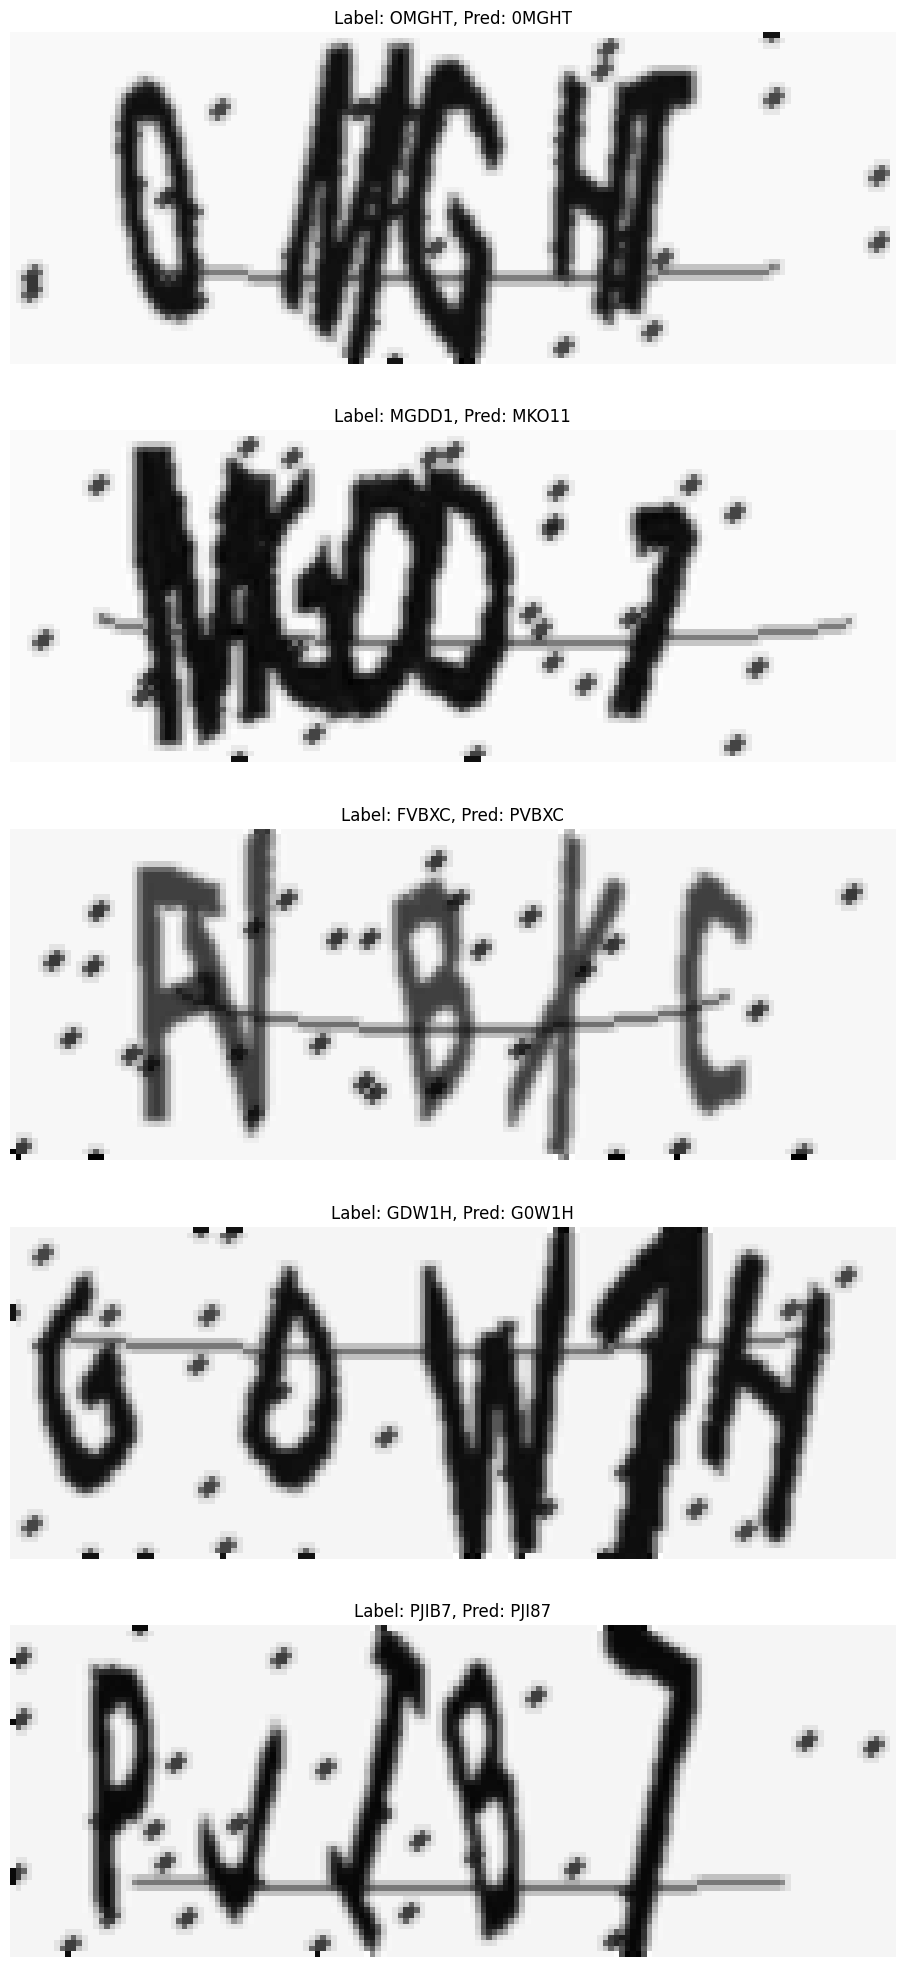

In [67]:
plotSamples(wrong_samples[5:])